# Example C

In this notebook, we will generate all the figures produced regarding Example C

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import sigmax, sigmay, sigmaz, steadystate, smesolve
from scipy import signal, fft

from FCS import TwoTimeCorrelationSS, FCSPowerSpectrumLinear

plt.rcParams.update({
    "text.usetex": True,
    "font.size" : 24})

In [2]:
# Define sytem parameters
gamma = [0.2, 20]
Omega = 1
Delta = 0

# Define Pauli spin operators
sx, sy, sz = sigmax(), sigmay(), sigmaz()

# Define system Hamiltonian 
H = Omega*sx + (Delta/2) * sz

# Define collapse operators for two examples
c_ops = [(g)**0.5 * sigmaz() for g in gamma]

# Steady-state in this example is maximally mixed state for both examples
rhoss = steadystate(H, [c_ops[0]])

Compute stochastic unravelling using Qutip smesolve

In [3]:
# Define long time evolution for signal processing later
tf = 500
dt = 0.001;
t = np.arange(0, tf, dt)

# Specify random seed
seed = 1

# Define Current list and observable list, power spectrum, and two-time correlation functiom
I_diff = []
sze = []

# Loop over different c_ops values and obtain one trajectory each and append to lists
for c_op in c_ops:
    result = smesolve(H, rhoss, t, sc_ops=[c_op], e_ops=[sz], store_measurement=True, noise=seed)
    I_diff.append(np.real(result.measurement[0].T[0]))
    sze.append(result.expect[0])

Total run time:   5.32s
Total run time:   5.32s


Plot figure of conditional expectation value

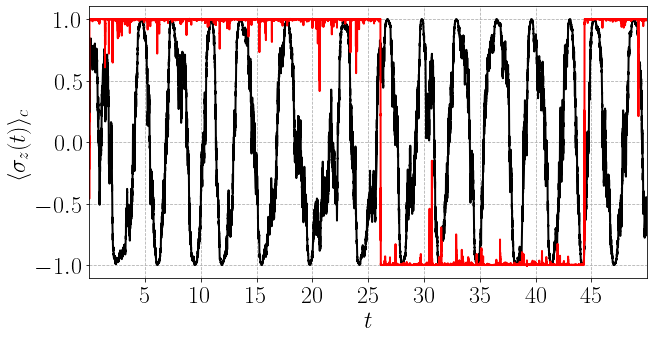

In [4]:
fig1 = plt.figure(figsize=(10, 5))
lw = 2
tfi = 50

plt.plot(t[t<tfi], sze[0][t<tfi], linewidth=lw, color='k')
plt.plot(t[t<tfi], sze[1][t<tfi], linewidth=lw, color='r')

plt.grid(True, linestyle='--')
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.xticks(np.arange(5, tfi, 5))
plt.xlim([0, tfi])
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \sigma_{z}(t)\rangle_{c}$')

plt.show()

In [5]:
# Define frequency space to compute over
omega0 = 15
domega = 0.011
omega = np.arange(-omega0, omega0, domega)

# Define tau list for two-time correlation function
tau = np.linspace(0, 30, 500)

# Define Current list and observable list, power spectrum, and two-time correlation functiom
Somega = []
Ftau = []

# Loop over different c_ops values and compute power spectrum and two-time correlation function
for c_op in c_ops:
    Somega.append(FCSPowerSpectrumLinear(H, [c_op], rhoss, omega, [c_op], [1], method='Homodyne'))
    Ftau.append(TwoTimeCorrelationSS(H, tau, [c_op], rhoss, [c_op], [1], method='Homodyne'))

Plot results

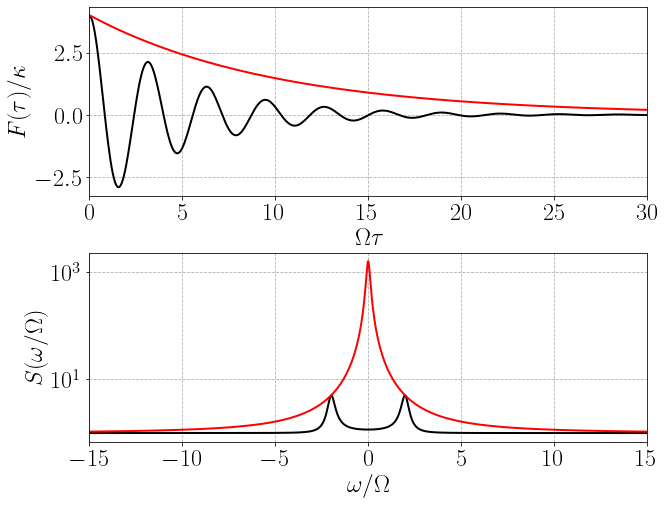

In [6]:
fig2 = plt.figure(figsize=(10, 8))

plt.subplot(2, 1,1)

plt.plot(Omega*tau, Ftau[0]/gamma[0], linewidth=lw, color='k')
plt.plot(Omega*tau, Ftau[1]/gamma[1], linewidth=lw, color='r')

plt.xticks(np.arange(0, 35, 5))
plt.xlabel(r'$\Omega \tau$')
plt.ylabel(r'$F(\tau)/\kappa $')
plt.grid(True, linestyle='--')
plt.xlim([0, tau[-1]])

plt.subplot(2, 1,2)

plt.plot(omega/Omega, Somega[0], linewidth=lw, color='k')
plt.plot(omega/Omega, Somega[1], linewidth=lw, color='r')

plt.xlabel(r'$\omega/\Omega$')
plt.ylabel(r'$S(\omega/\Omega) $')
plt.grid(True, linestyle='--')
plt.yscale('log')
plt.xlim([-omega0, omega0])

plt.subplots_adjust(wspace=0, hspace=0.3)

plt.show()

Signal processing

In [7]:
# Fourier transform raw currents
F1, F2 = fft.fft(I_diff[0]), fft.fft(I_diff[1])

# Construct frequencies
omegaf = fft.fftfreq(len(t), dt)[:len(t)//2]*2*np.pi

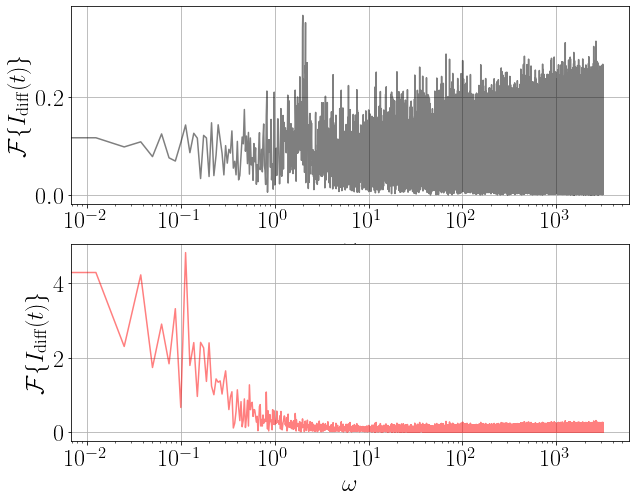

In [8]:
fig3 = plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
plt.plot(omegaf, 2/len(t) * np.abs(F1[0:len(t)//2]), color='k', alpha=0.5)
plt.xscale('log')
plt.ylabel(r'$\mathcal{F}\{I_{\rm diff}(t)\}$')
plt.xlabel(r'$\omega$')
plt.grid()

plt.subplot(2,1,2)
plt.plot(omegaf, 2/len(t) * np.abs(F2[0:len(t)//2]), color='r',  alpha=0.5)
plt.xscale('log')
plt.ylabel(r'$\mathcal{F}\{I_{\rm diff}(t)\}$')
plt.xlabel(r'$\omega$')

plt.grid()
plt.show()

In [9]:
# Central angular frequency
# You can be more systematic in choosing all these parameters
lowcut = (Omega/(np.pi))-0.1
highcut = (Omega/(np.pi))+0.1

# Create first order bandpass butterworth filter
b1, a1 = signal.butter(1, [lowcut, highcut], 'bandpass', fs=1/dt)
w1, h1 = signal.freqz(b1, a1, fs=1/dt, whole=False)

# Create first order lowpass butterworth filter
b2, a2 = signal.butter(1, Omega, 'lowpass', fs=1/dt)
w2, h2 = signal.freqz(b2, a2, fs=1/dt, whole=False)

# Filter the signals
filtered_I_diff0 = signal.lfilter(b1, a1, I_diff[0])
filtered_I_diff1 = signal.lfilter(b2, a2, I_diff[1])

# Get Fourier transforms of filtered signals
F1_filt, F2_filt = fft.fft(filtered_I_diff0), fft.fft(filtered_I_diff1)

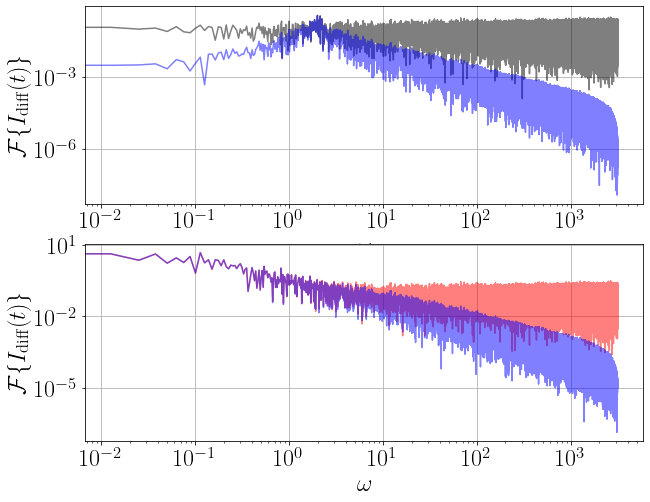

In [10]:
fig4 = plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
plt.plot(omegaf, 2/len(t) * np.abs(F1[0:len(t)//2]), color='k', alpha=0.5)
plt.plot(omegaf, 2/len(t) * np.abs(F1_filt[0:len(t)//2]), color='b', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\mathcal{F}\{I_{\rm diff}(t)\}$')
plt.xlabel(r'$\omega$')
plt.grid()

plt.subplot(2,1,2)
plt.plot(omegaf, 2/len(t) * np.abs(F2[0:len(t)//2]), color='r',  alpha=0.5)
plt.plot(omegaf, 2/len(t) * np.abs(F2_filt[0:len(t)//2]), color='b', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\mathcal{F}\{I_{\rm diff}(t)\}$')
plt.xlabel(r'$\omega$')

plt.grid()
plt.show()

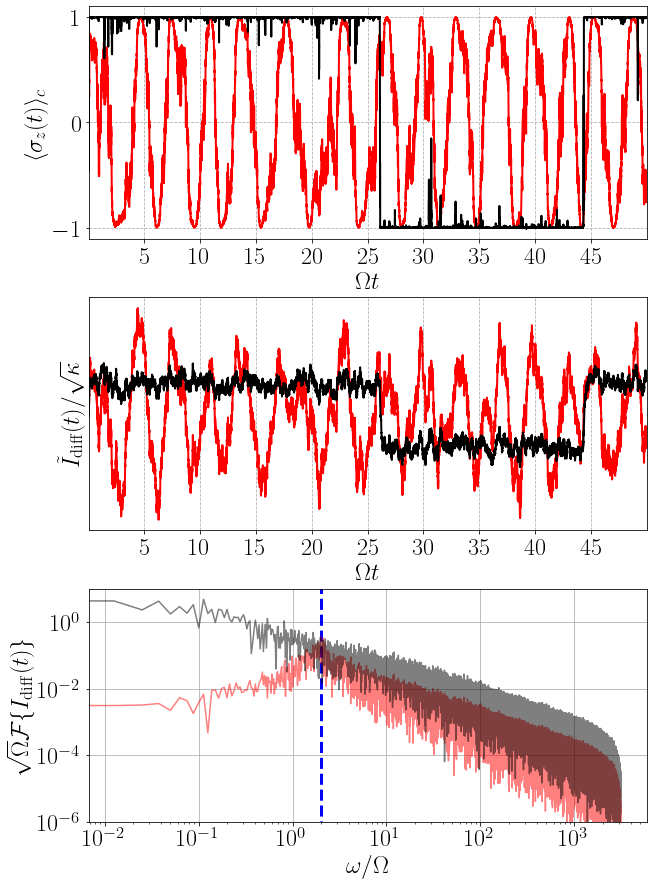

In [11]:
fig5 = plt.figure(figsize=(10, 15))
tfi = 50

plt.subplot(3, 1, 1)

plt.plot(t[t<tfi], sze[0][t<tfi], linewidth=lw, color='r')
plt.plot(t[t<tfi], sze[1][t<tfi], linewidth=lw, color='k')

plt.grid(True, linestyle='--')
plt.xticks(np.arange(5, tfi, 5))
plt.xlim([0, tfi])
plt.xlabel(r'$\Omega t$')
plt.ylabel(r'$\langle \sigma_{z}(t)\rangle_{c}$')

plt.subplot(3, 1, 2)

plt.plot(t[t<tfi], filtered_I_diff0[t<tfi]/np.sqrt(gamma[0]), linewidth=lw, color='r')
plt.plot(t[t<tfi], filtered_I_diff1[t<tfi]/np.sqrt(gamma[1]), linewidth=lw, color='k')

plt.grid(True, linestyle='--')
plt.yticks([])
plt.xticks(np.arange(5, tfi, 5))
plt.xlim([0, tfi])
plt.xlabel(r'$\Omega t$')
plt.ylabel(r'$\tilde{I}_{\rm diff}(t)/\sqrt{\kappa}$')

plt.subplot(3, 1, 3)

plt.plot(omegaf, 2/len(t) * np.abs(F1_filt[0:len(t)//2]), color='r', alpha=0.5)
plt.plot(omegaf, 2/len(t) * np.abs(F2_filt[0:len(t)//2]), color='k', alpha=0.5)
plt.vlines(2*Omega, 0, 100, color='b', linestyle='--', linewidth=3)

plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\sqrt{\Omega}\mathcal{F}\{I_{\rm diff}(t)\}$')
plt.xlabel(r'$\omega/\Omega$')
plt.ylim([1e-6, 10])

plt.grid()

plt.subplots_adjust(wspace=0, hspace=0.25)

plt.show()

# Make plot of many trajectories 

In [12]:
# Evolve for shorter times but with larger number of trajectories
tf = 50
dt = 0.002;
t = np.arange(0, tf, dt)
ntraj = 1000

result = smesolve(H, rhoss, t, sc_ops=[c_ops[0]], e_ops=[sz], store_measurement=True, ntraj=ntraj)

10.0%. Run time:  26.99s. Est. time left: 00:00:04:02
20.0%. Run time:  53.57s. Est. time left: 00:00:03:34
30.0%. Run time:  80.04s. Est. time left: 00:00:03:06
40.0%. Run time: 106.49s. Est. time left: 00:00:02:39
50.0%. Run time: 133.93s. Est. time left: 00:00:02:13
60.0%. Run time: 160.62s. Est. time left: 00:00:01:47
70.0%. Run time: 187.86s. Est. time left: 00:00:01:20
80.0%. Run time: 214.83s. Est. time left: 00:00:00:53
90.0%. Run time: 241.46s. Est. time left: 00:00:00:26
Total run time: 267.95s


In [ ]:
# Compute time integrated current
Nt = np.array([np.real(np.cumsum(result.measurement[i].T[0])*dt) for i in range(ntraj)])

# Compute diffusion coefficient for given measurement rate
D = FCSPowerSpectrumLinear(H, [c_ops[0]], rhoss, [0.001], [c_ops[0]], [1], method='Homodyne')[0]

# Compute the Gaussian distribution 
Jvals = np.linspace(-D*tf, D*tf, 200)
dist = np.exp(-Jvals**2 / (2*D*tf)) * (1/np.sqrt(2*np.pi*D*tf))

In [ ]:
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
ax1.plot(gamma[0]*t, Nt.T, color='r', linewidth=0.01)
ax1.set_xlim([0, 10])
ax1.set_ylim([-dd, dd])
ax1.set_xlabel(r'$\kappa t$')
ax1.set_ylabel(r'$N_{\rm diff}(t)$')

ax2 = plt.subplot2grid((1, 4), (0, 3), colspan=1)
ax2.hist(Nt[:, -1], bins=50, density=True, orientation='horizontal', color='r', alpha=0.5)
ax2.plot(dist, Jvals, color='k')
ax2.vlines(0, -30, 30, color='k')
ax2.set_ylim([-dd, dd])

ax2.set_yticks([])
ax2.set_xticks([])

plt.subplots_adjust(wspace=0.02, hspace=0.3)

plt.show()